In [ ]:
# Esta es la Parte 3 del código principal del TFG: Modelado de tópicos.
# Esta sección complementa la Parte 1, donde se realiza el preprocesamiento de datos y la PARTE 2, generación de N-gramas.
# Todas las partes han sido separadas por motivos de tamaño al subir el proyecto a GitHub, pero forman parte de un único flujo de trabajo.
# Es fundamental ejecutar previamente la Parte 1 en el mismo entorno para garantizar que todas las librerías estén cargadas y los datos correctamente preparados.
# También existe una versión unificada del proyecto en formato .py, que incluye todo el proceso completo.


In [ ]:
# 3. Modelado de Tópicos

#Se carga el csv obtenido ateriormente con los datos limpios para realizar el modelado de tópicos
df_modelado = pd.read_csv('Venezuela_limpia.csv')
print(df_modelado.head())

   Unnamed: 0                                             Título  \
0           0  I see many posts here saying that people want ...   
1           1  Collapse Comes Early for Canada: Prepare for U...   
2           2                         Predictions and Prophecies   
3           3  March 4, 2025 - Cataclysmic Shift and Future p...   
4           4  February 18, 2025, 4:17 pm | Nicaragua (NI) - ...   

                 Fecha            Subreddit           Autor        date  year  \
0  2025-02-19 11:33:02     TheHandmaidsTale        Poch1212  2025-02-19  2025   
1  2025-02-19 04:57:29         CollapsePrep       verdasuno  2025-02-19  2025   
2  2025-02-19 01:04:18             prophets    RosalieJewel  2025-02-19  2025   
3  2025-02-19 00:50:20  anonspropheticdream    RosalieJewel  2025-02-19  2025   
4  2025-02-18 16:17:56         ABCWorldNews  AcademicAd8273  2025-02-18  2025   

   month  day language  texto_length  \
0      2   19       en          2003   
1      2   19       en  

In [ ]:
#Se procede a realizar la tokenización
def tokenize(text):
    text = str(text)
    tokens = text.split()
    return tokens

In [ ]:
df_modelado['tokens'] = df_modelado['lemmas'].apply(tokenize) #Se añade una nueva columna llamada 'tokens' al DataFrame aplicando la tokenización a cada texto en la columna 'lemmas'
print(df_modelado.head()) #Se visualizan las primeras filas

   Unnamed: 0                                             Título  \
0           0  I see many posts here saying that people want ...   
1           1  Collapse Comes Early for Canada: Prepare for U...   
2           2                         Predictions and Prophecies   
3           3  March 4, 2025 - Cataclysmic Shift and Future p...   
4           4  February 18, 2025, 4:17 pm | Nicaragua (NI) - ...   

                 Fecha            Subreddit           Autor        date  year  \
0  2025-02-19 11:33:02     TheHandmaidsTale        Poch1212  2025-02-19  2025   
1  2025-02-19 04:57:29         CollapsePrep       verdasuno  2025-02-19  2025   
2  2025-02-19 01:04:18             prophets    RosalieJewel  2025-02-19  2025   
3  2025-02-19 00:50:20  anonspropheticdream    RosalieJewel  2025-02-19  2025   
4  2025-02-18 16:17:56         ABCWorldNews  AcademicAd8273  2025-02-18  2025   

   month  day language  texto_length  \
0      2   19       en          2003   
1      2   19       en  

In [ ]:
#Se importa una semilla para la reproducibilidad de los resultados
seed(24)
#Además, se crea un diccionario a partir de los tokens encontrados
id2word = Dictionary(df_modelado['tokens'])

In [ ]:
#Se filtran los extremos continuando con el proceso de limpieza
id2word.filter_extremes(no_below=2, no_above=.95)

In [ ]:
#Se crea el objeto del corpus
corpus = [id2word.doc2bow(d) for d in df_modelado['tokens']]

In [ ]:
# Se procede a encontrar el valor óptimo de k y para obtener los valores de coherencia
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=10)
        model_list_topic.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    return model_list_topic, coherence_values_topic

In [ ]:
# Se aplica la función definida en el paso anterior
model_list_topic, coherence_values_topic = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus,
    texts=df_modelado['tokens'],
    start=2,
    limit=15,
    step=1
)

In [ ]:
#Se crea un csv con los valores coherencia del rango de tópicos establecido en el paso anterior
#coherence_values_topic_df = pd.DataFrame(coherence_values_topic)
#coherence_values_topic_df.to_csv('coherence_values.csv', index=False)
coherence_values_topic_df= pd.read_csv('coherence_values.csv', index_col=False)
coherence_values_topic_df

,0
0,0.290365
1,0.286603
2,0.307631
3,0.368854
4,0.345713
5,0.360271
6,0.348501
7,0.402880
8,0.398572
9,0.409206


In [ ]:
#Se crea una lista con los valores de las columnas indicados
coherence_values_topic_df=coherence_values_topic_df.iloc[:, 0].tolist()

In [ ]:
# Genera la lista de X (por ejemplo, si coherence_values_topic_df tiene 13 elementos)
x_values = list(range(2, 2 + len(coherence_values_topic_df)))

# Selecciona el número de tópicos deseado
selected_topic = 4
selected_index = x_values.index(selected_topic)
x_selected = x_values[selected_index]
y_selected = coherence_values_topic_df[selected_index]

# Dibuja la gráfica
plt.figure(figsize=(10, 7))
estrella = mpath.Path.unit_regular_star(8)
circulo = mpath.Path.unit_circle()
verts = np.concatenate([circulo.vertices, estrella.vertices[::-1, ...]])
codes = np.concatenate([circulo.codes, estrella.codes])
cut_star = mpath.Path(verts, codes)

plt.plot(x_values, coherence_values_topic_df, '--r', marker="o", markersize=10, fillstyle='none')
plt.axvline(x=x_selected, color='b', linestyle='--')
plt.plot(x_selected, y_selected, '--r', marker=cut_star, markersize=18)
plt.xlabel('Número de tópicos')
plt.ylabel('Índice de coherencia')
#plt.show()

In [ ]:
#Se genera el modelo LDA con el número de k elegido que en este caso k=4
k=4
model_k4 = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=k,
                                        passes=10,
                                        random_state=23)

In [ ]:
#Se procede a guardar y cargar todos los resultados obtenidos del modelo
#model_k4.save("model_4_topics.model")


In [ ]:
# Se carga del modelo LDA previamente guardado (este paso se realiza en caso de ya haber runeado el código y tener guardado mi modelo en el ordenador, evitando así emplear otro modelo diferente)
model_k4_load = LdaMulticore.load("model_4_topics.model")

In [ ]:
#Se calcula el coherence value
coherence_model_k4 = CoherenceModel(model=model_k4_load, texts=df_modelado['tokens'],
                                   dictionary=id2word, coherence='c_v')
coherence_model_k4 = coherence_model_k4.get_coherence()
print('\nCoherence Score: ', coherence_model_k4)


Coherence Score:  0.3395894453401642


In [ ]:
#Se observan las 10 palaras más utilizadas en cada uno de los 5 tópicos
print(model_k4_load.print_topics())
doc_lda = model_k4_load[corpus]
#Se filtra por palabras
words = [re.findall(r'"([^"]*)"',t[1]) for t in model_k4_load.print_topics()]
#Se crean los tópicos
topics = [' '.join(t[0:10]) for t in words]
for id, t in enumerate(topics):
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

[(0, '0.007*"migrant" + 0.006*"country" + 0.006*"trump" + 0.006*"citizen" + 0.006*"election" + 0.006*"government" + 0.005*"say" + 0.005*"administration" + 0.005*"tiny" + 0.005*"american"'), (1, '0.011*"order" + 0.009*"federal" + 0.007*"trump" + 0.005*"program" + 0.005*"fire" + 0.004*"department" + 0.004*"freeze" + 0.004*"funding" + 0.004*"employee" + 0.004*"year"'), (2, '0.014*"trump" + 0.009*"view" + 0.007*"president" + 0.006*"war" + 0.006*"migrant" + 0.006*"say" + 0.005*"government" + 0.005*"country" + 0.004*"united" + 0.004*"venezuela"'), (3, '0.010*"trump" + 0.005*"state" + 0.004*"war" + 0.004*"political" + 0.004*"fix" + 0.004*"maga" + 0.004*"american" + 0.004*"world" + 0.004*"country" + 0.003*"vote"')]
------ Topic 0 ------
migrant country trump citizen election government say administration tiny american

------ Topic 1 ------
order federal trump program fire department freeze funding employee year

------ Topic 2 ------
trump view president war migrant say government country uni

In [ ]:
#Se pinta la distancia intertópica con pyLDAvis
pyLDAvis.enable_notebook()
gensimvis.prepare(model_k4_load, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.013163  0.039922       1        1  34.745976
3     -0.127328 -0.154963       2        1  23.436398
1      0.209312 -0.040587       3        1  21.883090
2     -0.068821  0.155628       4        1  19.934537, topic_info=          Term          Freq         Total Category  logprob  loglift
643       view  11354.000000  11354.000000  Default  30.0000  30.0000
424      order  23065.000000  23065.000000  Default  29.0000  29.0000
350    federal  17328.000000  17328.000000  Default  28.0000  28.0000
3849     hands   9988.000000   9988.000000  Default  27.0000  27.0000
850       tiny  10610.000000  10610.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
6     american   3659.712033  20953.447689   Topic4  -5.7997  -0.1322
220      state   3784.624789  24573.906525   Topic4  -5.7662  -0.2580
476        run   2720.676323   6103.165168   Topic4  -6.0962   0.8048
163       good   2817.722486   7600.139920   Topic4  -6.0612   0.6205
242       year   3130.191908  19676.836075   Topic4  -5.9560  -0.2256

[329 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
5988      4  0.999620   aaron
0         1  0.863302  accept
0         2  0.090874  accept
0         3  0.022095  accept
0         4  0.023520  accept
...     ...       ...     ...
5323      4  0.998798  yankee
242       1  0.374095    year
242       2  0.199880    year
242       3  0.266964    year
242       4  0.159070    year

[610 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [ ]:
#Se añade una columna de LDA features al modelo cargado para que nos de la importancia de cada tópico
def document_to_lda_features(model_k4_load,document):
  topic_importance=np.array(model_k4_load.get_document_topics(document, minimum_probability=0))
  return topic_importance[:,1]

In [ ]:
df_modelado['lda_features']=list(map(lambda doc: document_to_lda_features(model_k4_load,doc), corpus))

In [ ]:
#Se realiza la tokenización
def topic_important(item_score):
    score=np.argmax(item_score, axis=0)
    return score

In [ ]:
#Se aplica lo anterior y se visualiza la tabla obtenida
df_modelado['topic_dominant'] = df_modelado['lda_features'].apply(topic_important)
df_modelado

,Unnamed: 0,Título,Fecha,Subreddit,Autor,date,year,month,day,language,texto_length,cleaned_text,lemmas,tokens,lda_features,topic_dominant
0,0,I see many posts here saying that people want ...,2025-02-19 11:33:02,TheHandmaidsTale,Poch1212,2025-02-19,2025,2,19,en,2003,worked while ago hospital aiding refugees/ille...,work ago hospital aid refugee illegal migrant ...,"[work, ago, hospital, aid, refugee, illegal, m...","[0.5882583856582642, 0.0017938865348696709, 0....",0
1,1,Collapse Comes Early for Canada: Prepare for U...,2025-02-19 04:57:29,CollapsePrep,verdasuno,2025-02-19,2025,2,19,en,3265,"Long time lurker here, feeling compelled now p...",long time lurker feel compel post recent devel...,"[long, time, lurker, feel, compel, post, recen...","[0.0012788984458893538, 0.0012793521163985133,...",2
2,2,Predictions and Prophecies,2025-02-19 01:04:18,prophets,RosalieJewel,2025-02-19,2025,2,19,en,6415,"March , - Cataclysmic Shift and Future predict...",march cataclysmic shift future prediction hone...,"[march, cataclysmic, shift, future, prediction...","[0.0005457913503050804, 0.0005527912289835513,...",3
3,3,"March 4, 2025 - Cataclysmic Shift and Future p...",2025-02-19 00:50:20,anonspropheticdream,RosalieJewel,2025-02-19,2025,2,19,en,6357,honestly not like the word prophet because the...,honestly word prophet negative connotation ass...,"[honestly, word, prophet, negative, connotatio...","[0.0005515736993402243, 0.0005587744526565075,...",3
4,4,"February 18, 2025, 4:17 pm | Nicaragua (NI) - ...",2025-02-18 16:17:56,ABCWorldNews,AcademicAd8273,2025-02-18,2025,2,18,en,4460,___ . #### Nicaraguan Ambassador Carlos Eduard...,nicaraguan ambassador carlos eduardo diaz more...,"[nicaraguan, ambassador, carlos, eduardo, diaz...","[0.0013420108007267118, 0.0013415050925686955,...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13082,13082,Do Uncommitted/Jill Stein voters not realize t...,2024-09-14 20:58:21,millenials,zipzzo,2024-09-14,2024,9,14,en,4668,Can somebody explain the thought process here?...,explain thought process kamala ride super mode...,"[explain, thought, process, kamala, ride, supe...","[0.0009459355496801436, 0.0009458728018216789,...",3
13083,13083,"He's a proven rapist, serial liar, and busines...",2024-09-14 12:55:30,PoliticsVermont,RamaSchneider,2024-09-14,2024,9,14,en,1179,>Donald Trump repeated racist claims about Hai...,donald trump repeat racist claim haitian migra...,"[donald, trump, repeat, racist, claim, haitian...","[0.003085428150370717, 0.0030711779836565256, ...",2
13084,13084,Trump vows mass deportations from town rocked ...,2024-09-13 23:24:26,autotldr,autotldr,2024-09-13,2024,9,13,en,2632,"This the best ; could make, [original]( reduce...",good original reduce bot donald trump say mass...,"[good, original, reduce, bot, donald, trump, s...","[0.0022056405432522297, 0.0021934895776212215,...",2
13085,13085,Best longform profiles of the week,2024-09-13 22:46:32,longform,VegetableHousing139,2024-09-13,2024,9,13,en,17890,"Hey guys, ' back with some the best longform p...",hey guy good longform profile find week.**you ...,"[hey, guy, good, longform, profile, find, week...","[0.9993659257888794, 0.00021104945335537195, 0...",0


In [ ]:
#Se genera un csv con los resultados para guardarlos ya que serán empleados en el análisis de sentimientos posteriormente
df_modelado.to_csv('topic_model_results.csv', index=False)

In [ ]:
#Se saca el número de publicaciones por tópico
df_modelado["topic_dominant"].value_counts()

,count
topic_dominant,
0,4863
2,4484
3,2246
1,1494


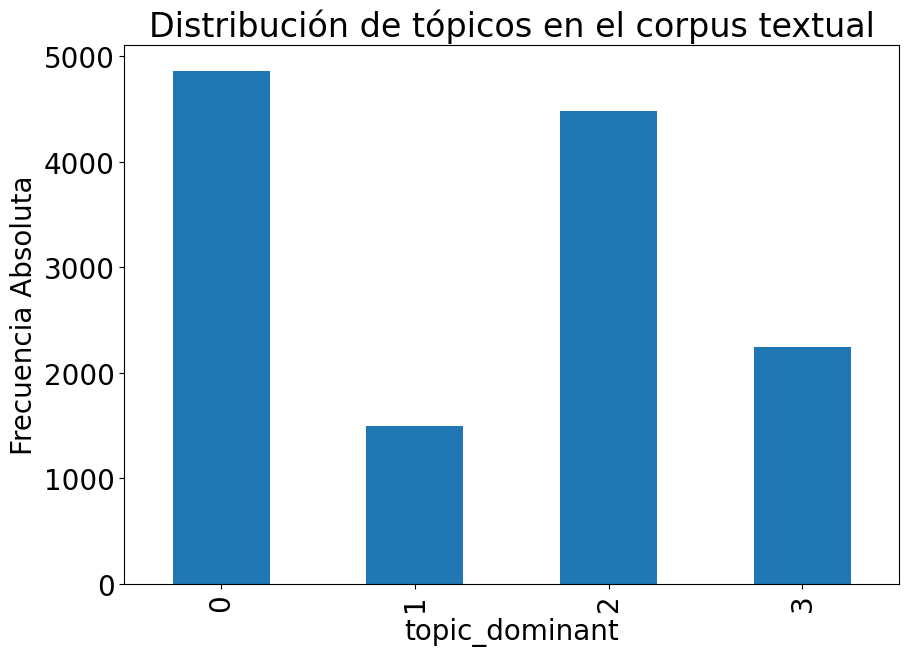

In [ ]:
#Se dibuja la distribución de los tópicos en un histograma
plt.figure(figsize=(10,7))
ax=df_modelado["topic_dominant"].value_counts().sort_index().plot(kind='bar')
plt.ylabel('Frecuencia Absoluta')
plt.title('Distribución de tópicos en el corpus textual')
plt.show()

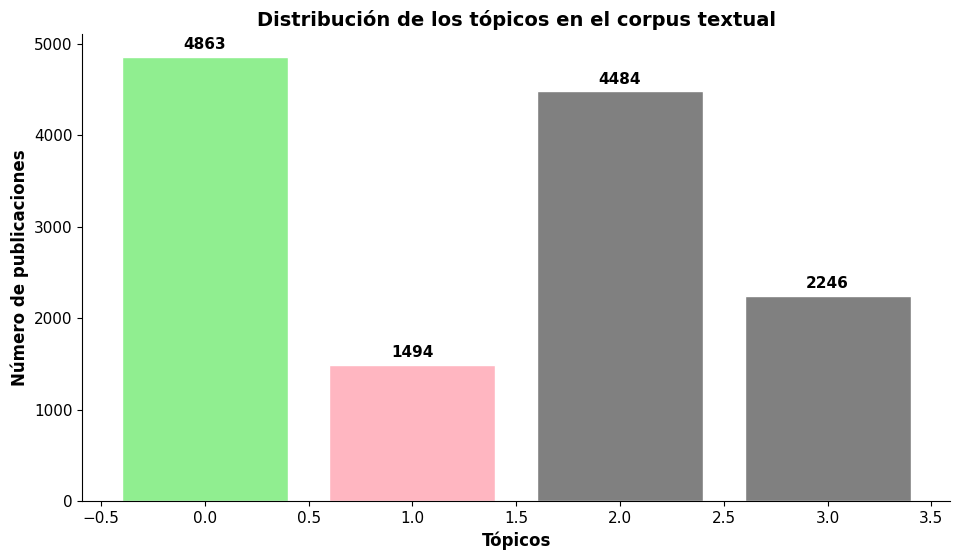

In [ ]:
# Se obtienen las cuentas de frecuencia y ordénalas por índice
# Obtuve esta visualización también de Flourish ()
topic_counts = df_modelado["topic_dominant"].value_counts().sort_index()

# Nombres de los tópicos (0, 1, 2, ..., N)
topics = topic_counts.index
counts = topic_counts.values

# Colores para replicar el estilo: primero verde, intermedios gris, último rosa
colors = ['lightgreen'] + ['lightpink'] + ['grey'] + ['grey']

# Se crea la figura y el eje
fig, ax = plt.subplots(figsize=(10, 6))

# Se dibujan las barras
bars = ax.bar(topics, counts, color=colors, edgecolor='white')

# Se añaden las etiquetas de frecuencia encima de cada barra
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 50,  # Ajusta "+50" según el espacio
            f'{count}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Se etiquetan de los ejes y título
ax.set_xlabel('Tópicos', fontsize=12, fontweight='bold')
ax.set_ylabel('Número de publicaciones', fontsize=12, fontweight='bold')
ax.set_title('Distribución de los tópicos en el corpus textual', fontsize=14, fontweight='bold')

# Se personaliza el estilo: sin bordes superiores/derechos, ticks más grandes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.tight_layout()
plt.show()


In [ ]:
#Se visualizan los bigramas de cada uno de los tópicos con mayor TF-IDF

#Tópico 1
topic_1 = df_modelado[df_modelado['topic_dominant']==0]
dft=topic_1['lemmas']
dft= [x for x in dft if str(x) != 'nan']
tfIdfVectorizer_bi=TfidfVectorizer(use_idf=True, ngram_range=(2,2))
tfIdf_bi = tfIdfVectorizer_bi.fit_transform(dft)
names_bi=tfIdfVectorizer_bi.get_feature_names_out()
freqs_bi = tfIdf_bi.sum(axis=0).A1
result_bi= dict(zip(names_bi, freqs_bi))
from operator import itemgetter
i = 0
results_sorted=sorted(result_bi.items(), key = itemgetter(1), reverse = True)
for key, value in results_sorted:
    i += 1
    if i == 11:
      break
    print(key, value)


tiny hands 161.72424302021196
united states 123.9957433451367
trump administration 86.81426346209874
rubio say 78.8499639593105
allow parole 77.7154254309019
refer allow 77.7154254309019
parole program 72.67259310906267
tren aragua 65.49414931014681
apartment complex 64.27092669110067
asylum seeker 57.50375601440022


Text(0.5, 1.0, 'Bigramas más relevantes en el tópico 1')

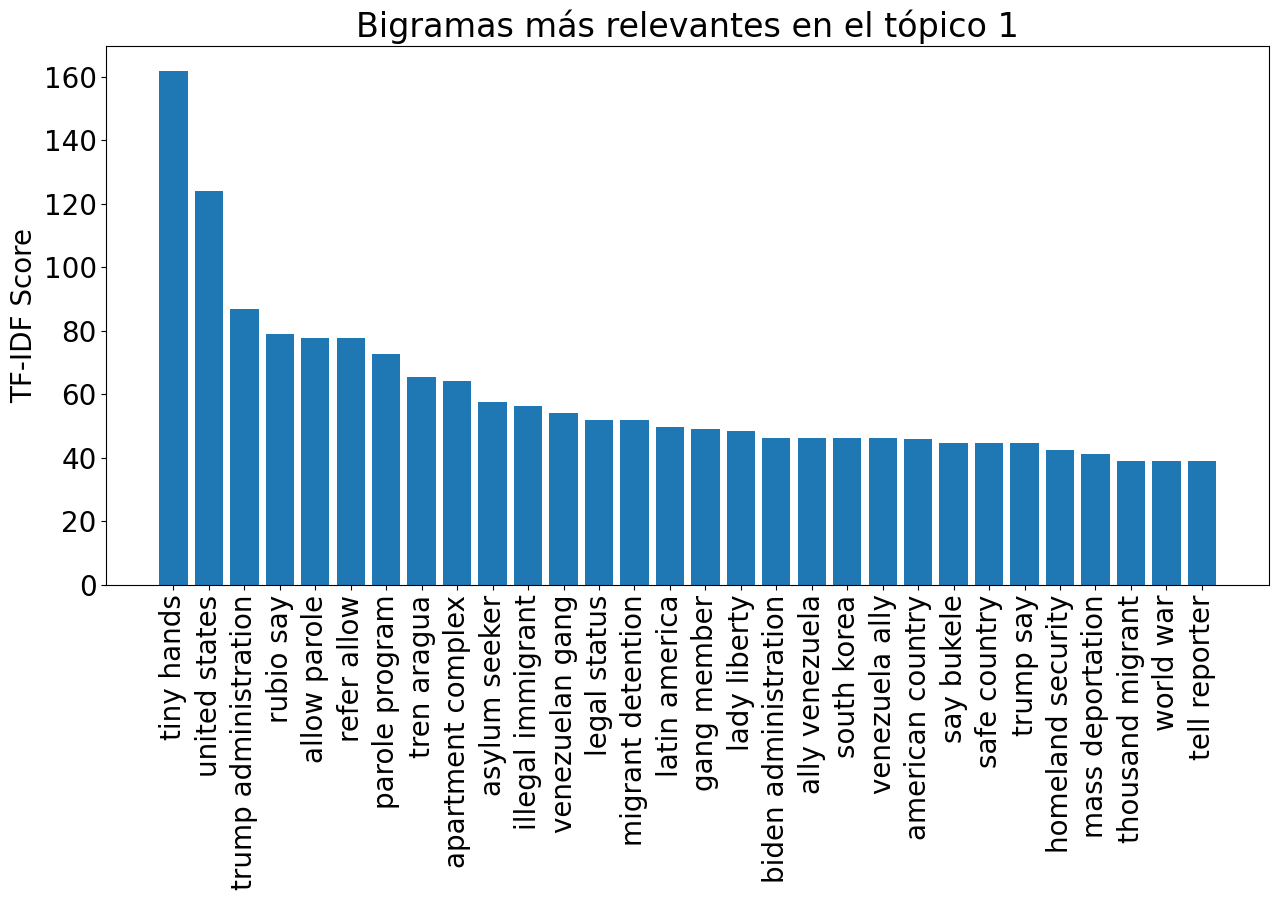

In [ ]:
#Se realiza el histograma
results_sorted_bi=sorted(result_bi.items(), key = itemgetter(1), reverse = True)
df_results_bi=pd.DataFrame.from_dict(results_sorted_bi).head(30)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,7))
plt.bar(df_results_bi[0],df_results_bi[1])
plt.xticks(rotation=90)
plt.ylabel('TF-IDF Score')
plt.title('Bigramas más relevantes en el tópico 1')

In [ ]:
#Tópico 2
topic_2 = df_modelado[df_modelado['topic_dominant']==1]
dft=topic_2['lemmas']
tfIdfVectorizer_bi=TfidfVectorizer(use_idf=True, ngram_range=(2,2))
tfIdf_bi = tfIdfVectorizer_bi.fit_transform(dft)
names_bi=tfIdfVectorizer_bi.get_feature_names_out()
freqs_bi = tfIdf_bi.sum(axis=0).A1
result_bi= dict(zip(names_bi, freqs_bi))
from operator import itemgetter
i = 0
results_sorted=sorted(result_bi.items(), key = itemgetter(1), reverse = True)
for key, value in results_sorted:
    i += 1
    if i == 11:
      break
    print(key, value)

executive order 45.70361098586845
biden administration 38.90589434504286
sign executive 37.19716993323079
federal worker 35.933550815080594
funding freeze 35.023662191405315
bird flu 32.076115254135466
federal employee 29.554163828159396
federal agency 29.293466044565942
international develop 28.539192438953812
trump plan 26.72262552265968


Text(0.5, 1.0, 'Bigramas más relevantes del tópico 2')

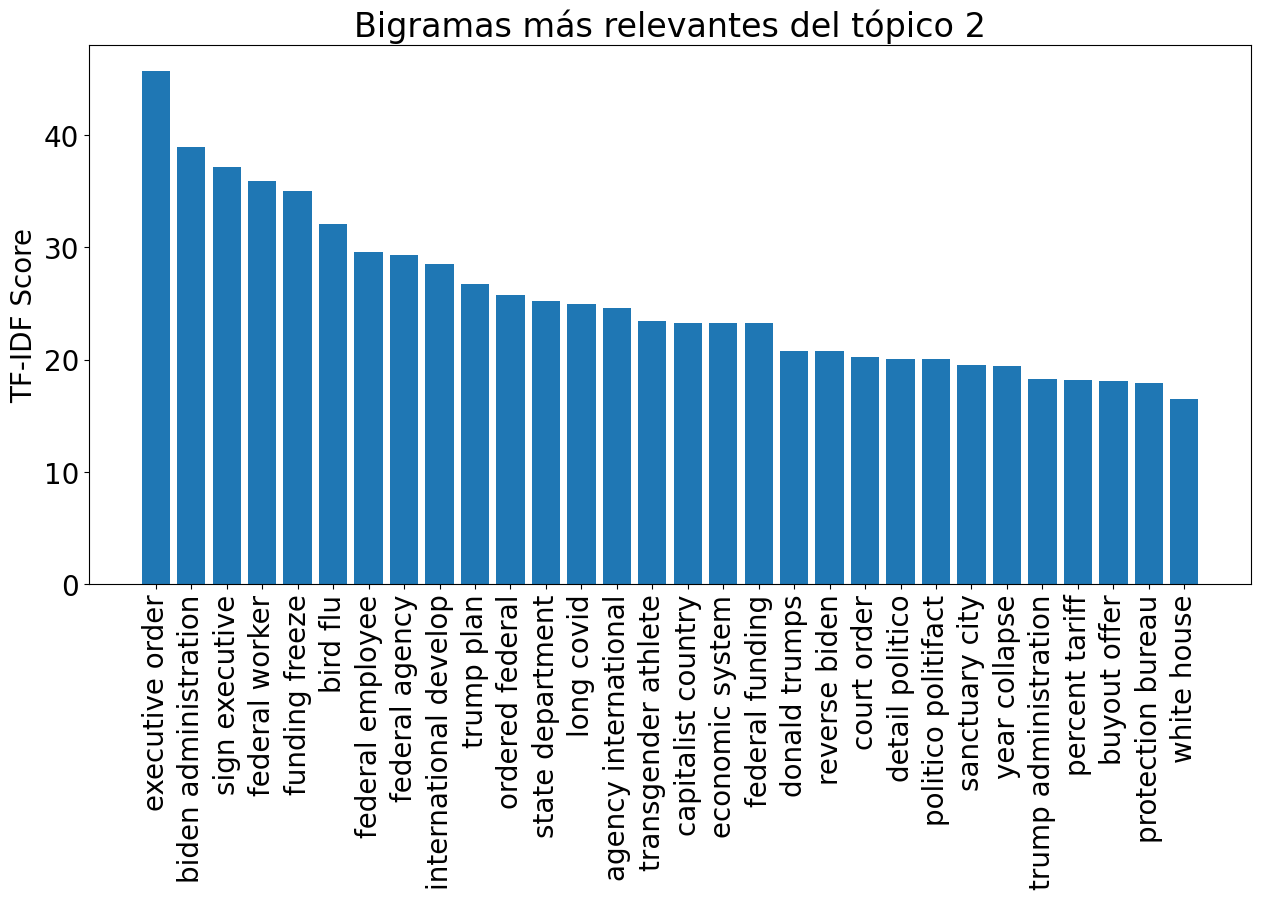

In [ ]:
#Se realiza el histograma
results_sorted_bi=sorted(result_bi.items(), key = itemgetter(1), reverse = True)
df_results_bi=pd.DataFrame.from_dict(results_sorted_bi).head(30)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,7))
plt.bar(df_results_bi[0],df_results_bi[1])
plt.xticks(rotation=90)
plt.ylabel('TF-IDF Score')
plt.title('Bigramas más relevantes del tópico 2')

In [ ]:
#Tópico 3
topic_3 = df_modelado[df_modelado['topic_dominant']==2]
dft=topic_3['lemmas']
dft= [x for x in dft if str(x) != 'nan']
tfIdfVectorizer_bi=TfidfVectorizer(use_idf=True, ngram_range=(2,2))
tfIdf_bi = tfIdfVectorizer_bi.fit_transform(dft)
names_bi=tfIdfVectorizer_bi.get_feature_names_out()
freqs_bi = tfIdf_bi.sum(axis=0).A1
result_bi= dict(zip(names_bi, freqs_bi))
from operator import itemgetter
i = 0
results_sorted=sorted(result_bi.items(), key = itemgetter(1), reverse = True)
for key, value in results_sorted:
    i += 1
    if i == 11:
      break
    print(key, value)

view nicaragua 96.48912121313107
united states 67.53473851776828
fox news 66.3228287914834
trump say 59.95395661065327
legal status 57.56985552170857
cuba venezuela 56.256429496690096
revoke legal 56.25631761050325
status immigrant 56.25631761050325
springfield ohio 54.53054195119957
large deportation 52.508795917387886


Text(0.5, 1.0, 'Bigramas más relevantes del tópico 3')

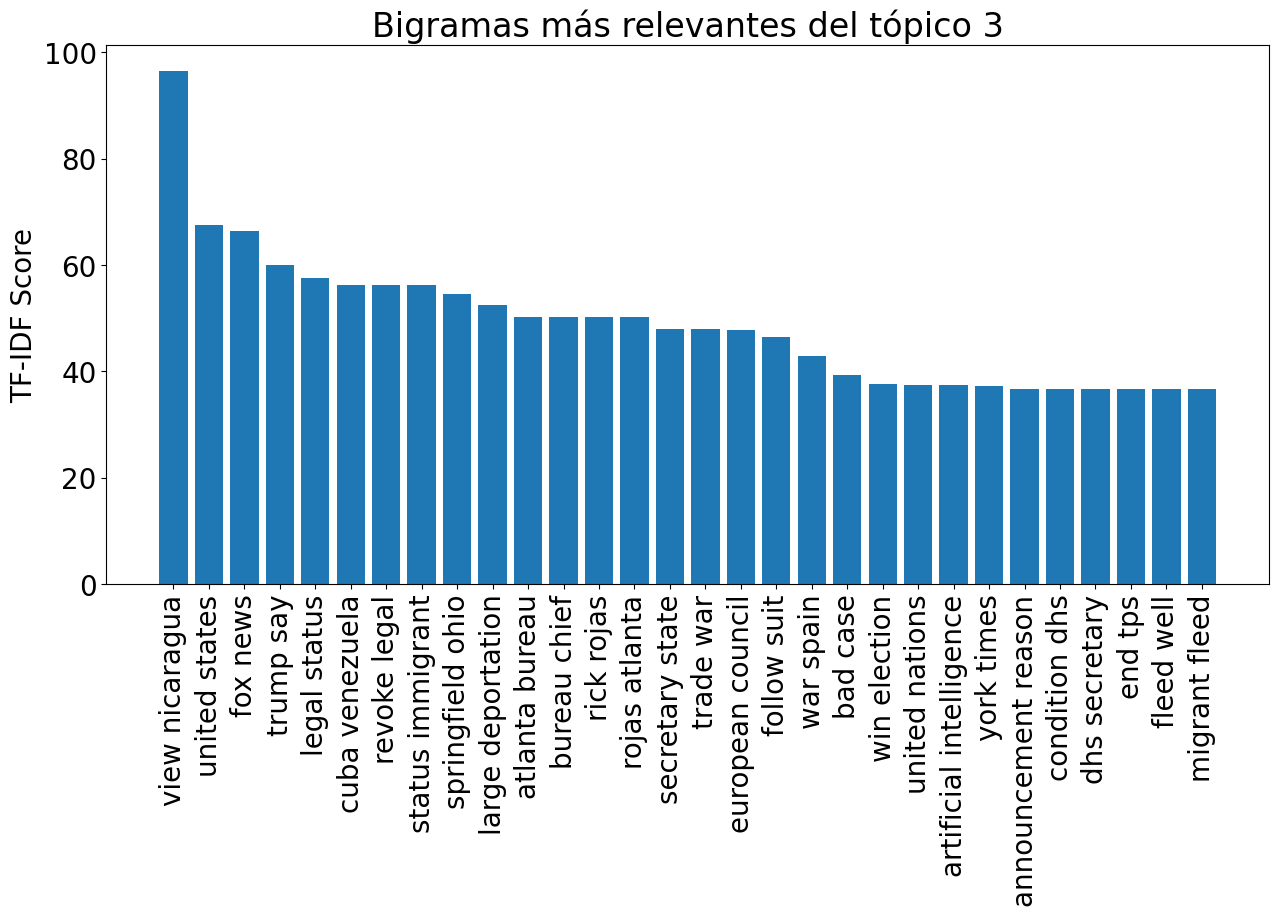

In [ ]:
#Se realiza el histograma
results_sorted_bi=sorted(result_bi.items(), key = itemgetter(1), reverse = True)
df_results_bi=pd.DataFrame.from_dict(results_sorted_bi).head(30)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,7))
plt.bar(df_results_bi[0],df_results_bi[1])
plt.xticks(rotation=90)
plt.ylabel('TF-IDF Score')
plt.title('Bigramas más relevantes del tópico 3')

In [ ]:
#Tópico 4
topic_4 = df_modelado[df_modelado['topic_dominant']==3]
dft=topic_4['lemmas']
tfIdfVectorizer_bi=TfidfVectorizer(use_idf=True, ngram_range=(2,2))
tfIdf_bi = tfIdfVectorizer_bi.fit_transform(dft)
names_bi=tfIdfVectorizer_bi.get_feature_names_out()
freqs_bi = tfIdf_bi.sum(axis=0).A1
result_bi= dict(zip(names_bi, freqs_bi))
from operator import itemgetter
i = 0
results_sorted=sorted(result_bi.items(), key = itemgetter(1), reverse = True)
for key, value in results_sorted:
    i += 1
    if i == 11:
      break
    print(key, value)

united states 55.19448199794903
cult leader 48.271955663518305
bashar assad 42.548745422430414
donald trump 38.90130389283009
niagara falls 38.08560556611964
crazy cult 36.20396674763882
north korea 33.883232546218586
able issue 31.250000000000004
anymore lmao 31.250000000000004
deportation long 31.250000000000004


Text(0.5, 1.0, 'Bigramas más relevantes del tópico 4')

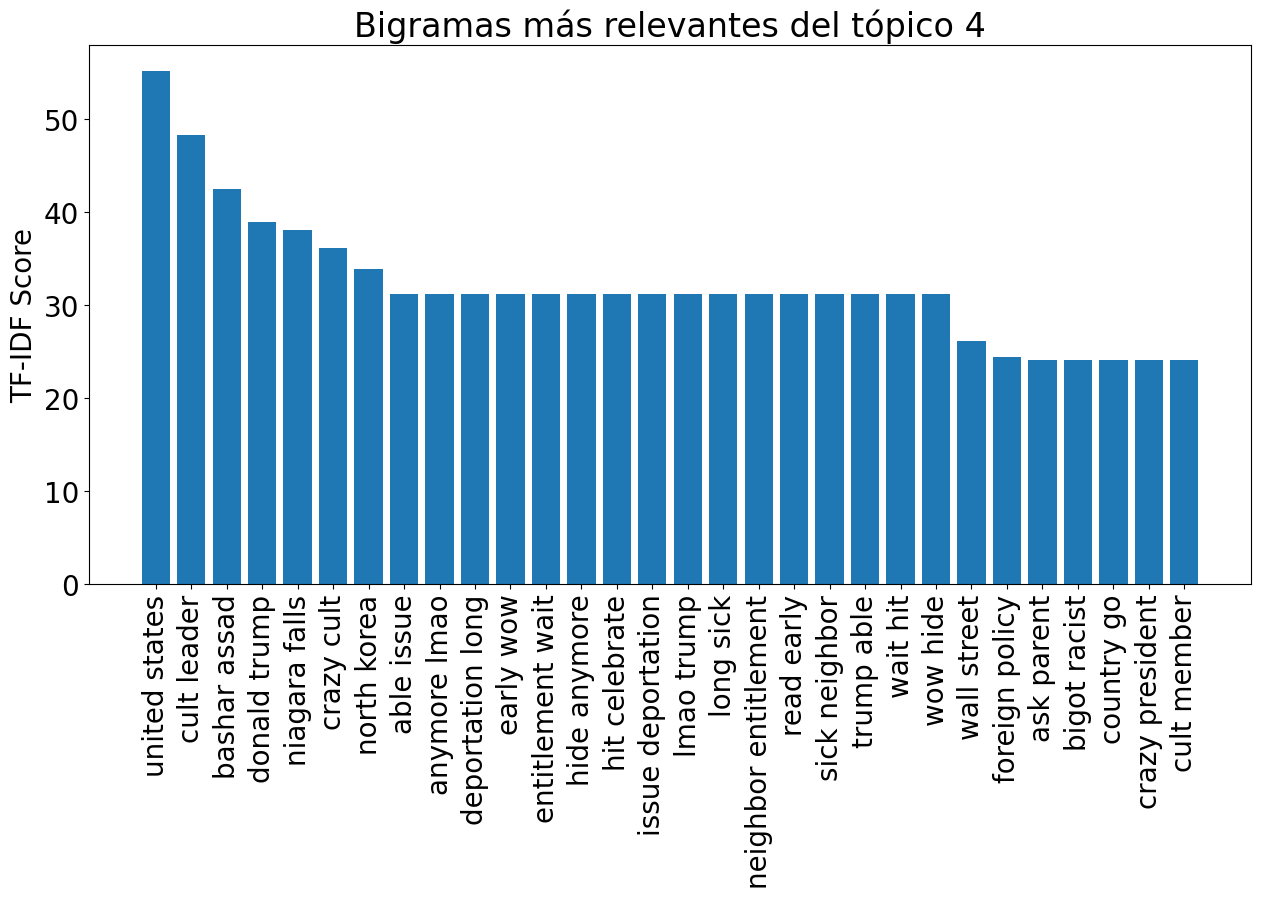

In [ ]:
#Se realiza el histograma
results_sorted_bi=sorted(result_bi.items(), key = itemgetter(1), reverse = True)
df_results_bi=pd.DataFrame.from_dict(results_sorted_bi).head(30)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,7))
plt.bar(df_results_bi[0],df_results_bi[1])
plt.xticks(rotation=90)
plt.ylabel('TF-IDF Score')
plt.title('Bigramas más relevantes del tópico 4')

In [ ]:
#Se realiza lo mismo que antes pero para los trigramas de cada uno de los tópicos

#Tópico 1
topic_1 = df_modelado[df_modelado['topic_dominant']==0]
dft=topic_1['lemmas']
dft= [x for x in dft if str(x) != 'nan']
tfIdfVectorizer_tri=TfidfVectorizer(use_idf=True, ngram_range=(3,3))
tfIdf_tri = tfIdfVectorizer_tri.fit_transform(dft)
names_tri= tfIdfVectorizer_tri.get_feature_names_out()
freqs_tri = tfIdf_tri.sum(axis=0).A1
result_tri = dict(zip(names_tri, freqs_tri))
from operator import itemgetter
i = 0
results_sorted=sorted(result_tri.items(), key = itemgetter(1), reverse = True)
for key, value in results_sorted:
    i += 1
    if i == 11:
      break
    print(key, value)

allow parole program 88.38834764831856
refer allow parole 88.38834764831856
member tren aragua 38.15787203737674
election tiny hands 35.43002262020321
tiny hands administration 35.43002262020321
rubio say bukele 34.369070699782704
administration send illegal 33.4076552390531
bay read article 33.4076552390531
block transfer migrant 33.4076552390531
center guantnamo bay 33.4076552390531


Text(0.5, 1.0, 'Trigramas más relevantes del tópico 1')

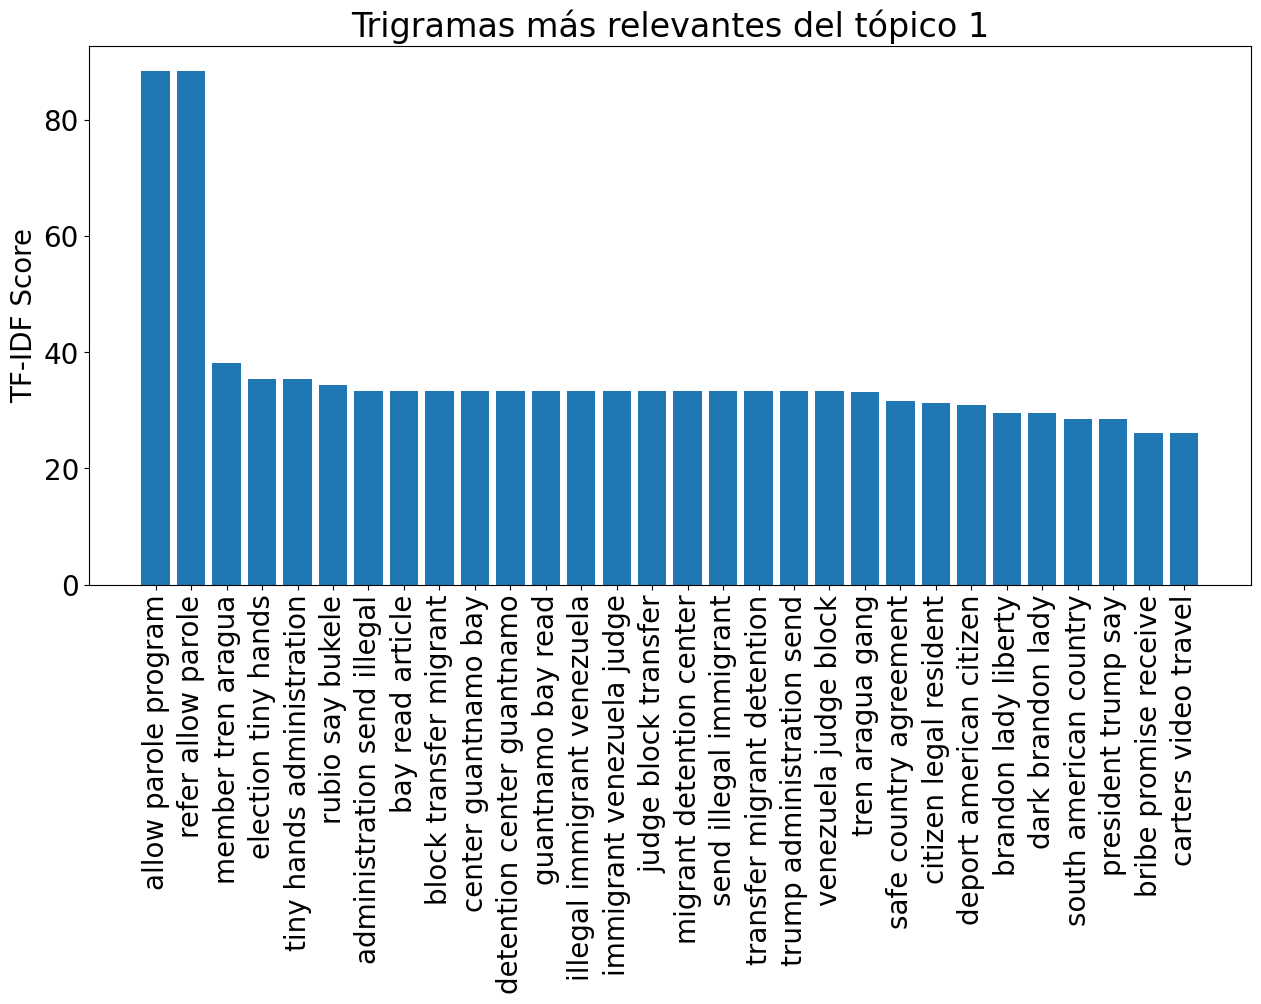

In [ ]:
#Se realiza el histograma
results_sorted_tri=sorted(result_tri.items(), key = itemgetter(1), reverse = True)
df_results_tri=pd.DataFrame.from_dict(results_sorted_tri).head(30)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,7))
plt.bar(df_results_tri[0],df_results_tri[1])
plt.xticks(rotation=90)
plt.ylabel('TF-IDF Score')
plt.title('Trigramas más relevantes del tópico 1')


In [ ]:
#Tópico 2
topic_2 = df_modelado[df_modelado['topic_dominant']==1]
dft=topic_2['lemmas']
tfIdfVectorizer_tri=TfidfVectorizer(use_idf=True, ngram_range=(3,3))
tfIdf_tri = tfIdfVectorizer_tri.fit_transform(dft)
names_tri= tfIdfVectorizer_tri.get_feature_names_out()
freqs_tri = tfIdf_tri.sum(axis=0).A1
result_tri = dict(zip(names_tri, freqs_tri))
from operator import itemgetter
i = 0
results_sorted=sorted(result_tri.items(), key = itemgetter(1), reverse = True)
for key, value in results_sorted:
    i += 1
    if i == 11:
      break
    print(key, value)


sign executive order 38.049948314988185
agency international develop 25.285115695000364
ordered federal agency 21.266800891918628
federal funding freeze 16.755391067884478
office personnel management 16.551179587915584
consumer financial protection 16.17497373316111
financial protection bureau 16.17497373316111
federal immigration enforcement 15.655607277128778
gonzlez venezuelan president 15.655607277128778
pass sanctuary city 15.655607277128778


Text(0.5, 1.0, 'Trigramas más relevantes del tópico 2')

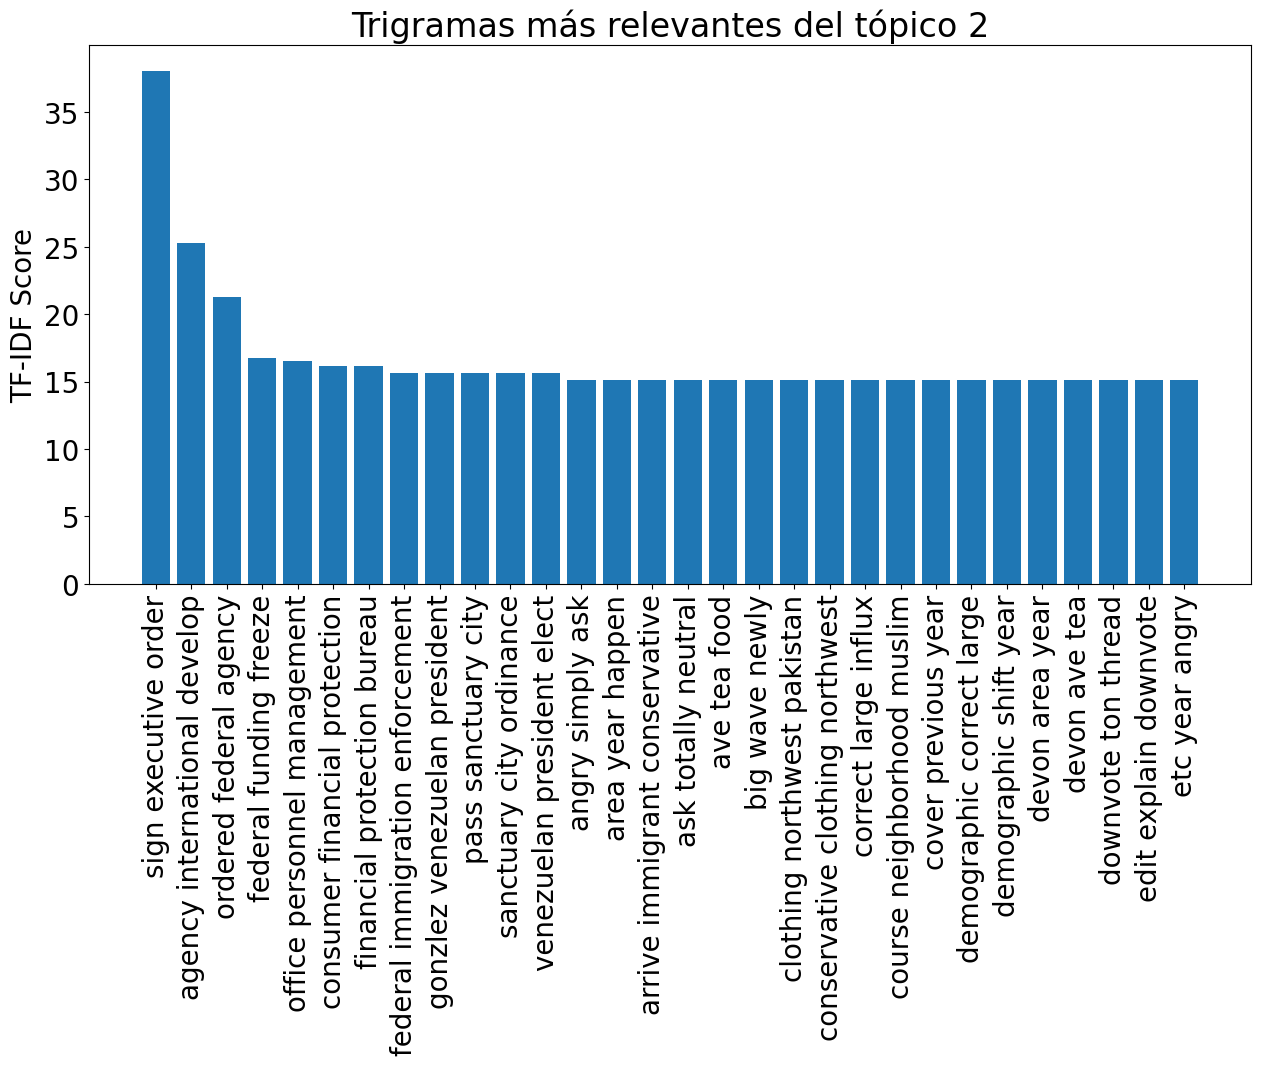

In [ ]:
#Se realiza el histograma
results_sorted_tri=sorted(result_tri.items(), key = itemgetter(1), reverse = True)
df_results_tri=pd.DataFrame.from_dict(results_sorted_tri).head(30)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,7))
plt.bar(df_results_tri[0],df_results_tri[1])
plt.xticks(rotation=90)
plt.ylabel('TF-IDF Score')
plt.title('Trigramas más relevantes del tópico 2')

In [ ]:
#Tópico 3
topic_3 = df_modelado[df_modelado['topic_dominant']==2]
dft=topic_3['lemmas']
tfIdfVectorizer_tri=TfidfVectorizer(use_idf=True, ngram_range=(3,3))
tfIdf_tri = tfIdfVectorizer_tri.fit_transform(dft)
names_tri= tfIdfVectorizer_tri.get_feature_names_out()
freqs_tri = tfIdf_tri.sum(axis=0).A1
result_tri = dict(zip(names_tri, freqs_tri))
from operator import itemgetter
i = 0
results_sorted=sorted(result_tri.items(), key = itemgetter(1), reverse = True)
for key, value in results_sorted:
    i += 1
    if i == 11:
      break
    print(key, value)

legal status immigrant 55.9689266835242
revoke legal status 55.9689266835242
atlanta bureau chief 50.46934073153422
rick rojas atlanta 50.46934073153422
rojas atlanta bureau 50.46934073153422
announcement reason end 37.68891807222048
condition dhs secretary 37.68891807222048
dhs secretary state 37.68891807222048
fleed well condition 37.68891807222048
migrant fleed well 37.68891807222048


Text(0.5, 1.0, 'Trigramas más relevantes del tópico 3')

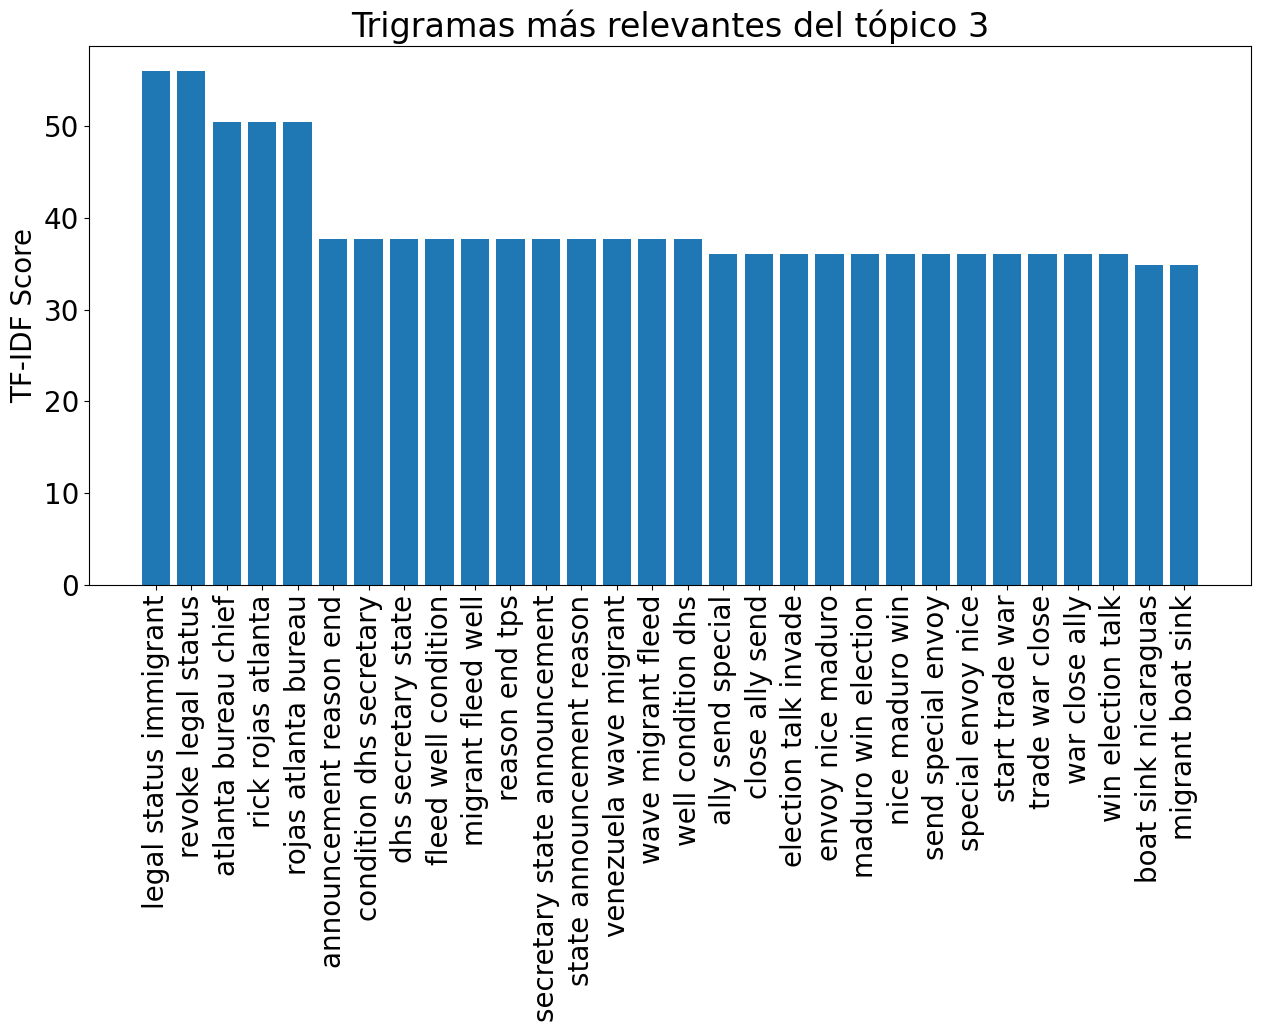

In [ ]:
#Se realiza el histograma
results_sorted_tri=sorted(result_tri.items(), key = itemgetter(1), reverse = True)
df_results_tri=pd.DataFrame.from_dict(results_sorted_tri).head(30)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,7))
plt.bar(df_results_tri[0],df_results_tri[1])
plt.xticks(rotation=90)
plt.ylabel('TF-IDF Score')
plt.title('Trigramas más relevantes del tópico 3')

In [ ]:
#Tópico 4
topic_4 = df_modelado[df_modelado['topic_dominant']==3]
dft=topic_4['lemmas']
tfIdfVectorizer_tri=TfidfVectorizer(use_idf=True, ngram_range=(3,3))
tfIdf_tri = tfIdfVectorizer_tri.fit_transform(dft)
names_tri= tfIdfVectorizer_tri.get_feature_names_out()
freqs_tri = tfIdf_tri.sum(axis=0).A1
result_tri = dict(zip(names_tri, freqs_tri))
from operator import itemgetter
i = 0
results_sorted=sorted(result_tri.items(), key = itemgetter(1), reverse = True)
for key, value in results_sorted:
    i += 1
    if i == 11:
      break
    print(key, value)

crazy cult leader 38.32320977306998
able issue deportation 32.27486121839507
anymore lmao trump 32.27486121839507
deportation long sick 32.27486121839507
early wow hide 32.27486121839507
entitlement wait hit 32.27486121839507
hide anymore lmao 32.27486121839507
issue deportation long 32.27486121839507
lmao trump able 32.27486121839507
long sick neighbor 32.27486121839507


Text(0.5, 1.0, 'Trigramas más relevantes del tópico 4')

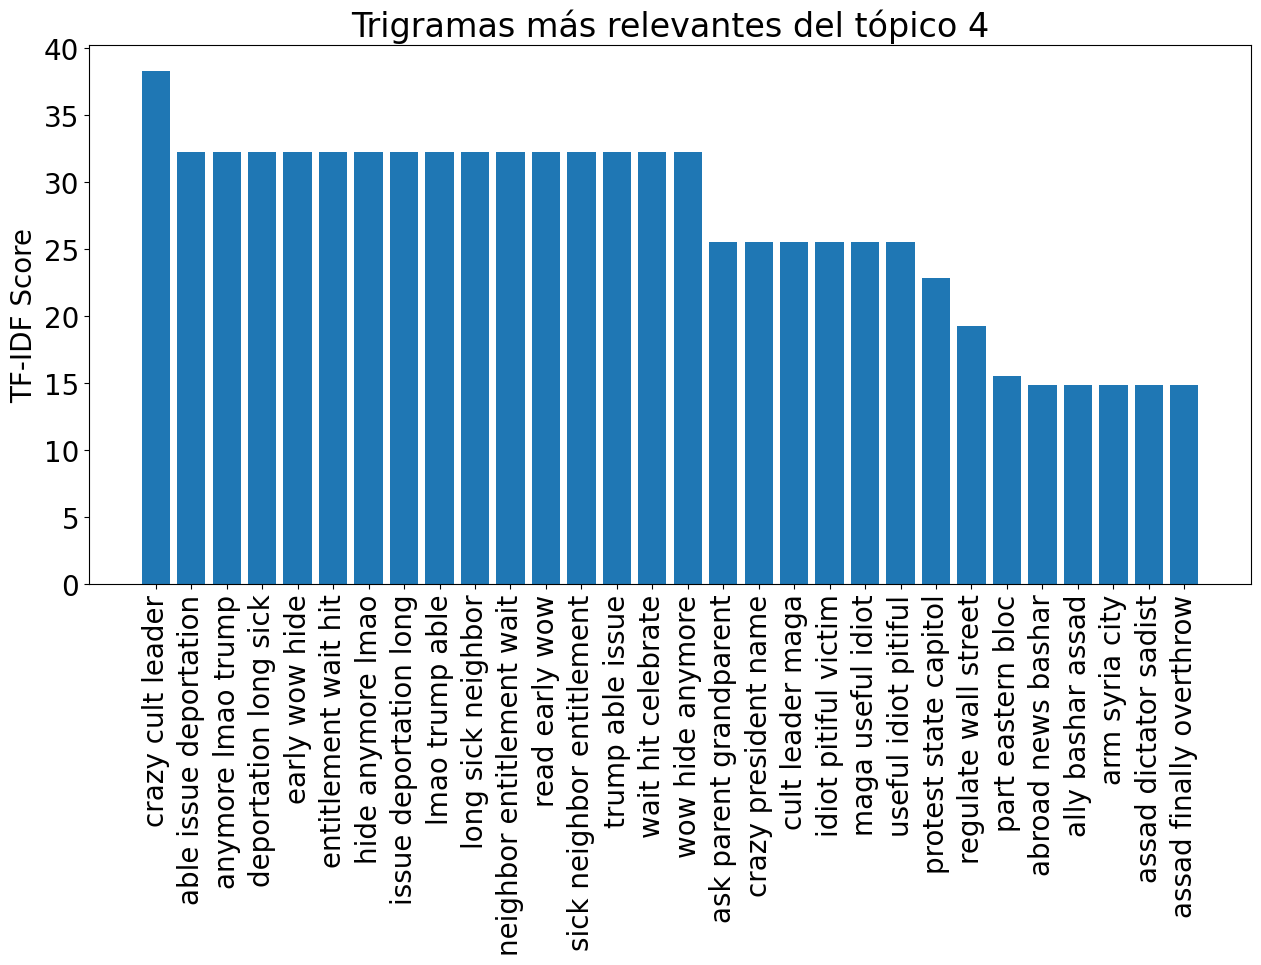

In [ ]:
#Se realiza el histograma
results_sorted_tri=sorted(result_tri.items(), key = itemgetter(1), reverse = True)
df_results_tri=pd.DataFrame.from_dict(results_sorted_tri).head(30)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,7))
plt.bar(df_results_tri[0],df_results_tri[1])
plt.xticks(rotation=90)
plt.ylabel('TF-IDF Score')
plt.title('Trigramas más relevantes del tópico 4')